<a href="https://colab.research.google.com/github/zzhang2017/Coursera_Capstone/blob/master/Crime_in_Boston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crime in Boston Neighborhoods
#### CAPSTONE 
_Zoe Zhang_

### -------------------------------------------------------------------------------------------------------

## __Introduction__
This final project explores if a specific neighborhood in Boston is safe and if more Police Station is associated with lower crime incidents, by looking at a city’s Crime Incident open data, and the Police Station venue data from Foursquare.

The historical data set has a time and space dimension for different types of crimes in the city. Analysis and visualization of the crime types and their trends can help us to understand the crime dynamics in the city.

## __Problem Statement__
Predict the probability of some rare event (violent crimes in this case) happening on a specific date with a spatial feature, to inform the police force can use this to concentrate on specific parts of the city each day to prevent violent crimes or at least increase the chance of patrolling there.

1.	Is there seasonaility when crimes are more likely to occur in a year? Has the crime incidents been growing or trending down overall? 
2.  What is / are the safest Neighborhood in Boston with lowest Crime incidence rate?
3.  Which neighborhoods is most safe in terms of how dense Police Station are placed in a given Neighborhood?

*Notes: Normalization by unit area method was adopted to address to the square miles variance across all Neighborhoods. Limitation may exist by adopting a geographic area unit normalization. For instance, it does not take into account of the population in a neighborhood or covered by a specific Police Station, or number of police officers in a Police Station.*

## __Methodology__
####__Data Collection__

> The crime incident open data in Boston neighborhoods is studied to answer the above questions.
> Crime incident reports are provided by Boston Police Department (BPD) to document the initial details surrounding an incident to which BPD officers respond. This is a dataset containing records from the new crime incident report system, which includes a reduced set of fields focused on capturing the type of incident as well as when and where it occurred, specifically, these elements are included:

*   Incident number: Unique identifier for the incident
*   Offense Code Group: Incidents are grouped with crime types
*   Reporting Area: The code for the reporting areas or zones.
*   Occurred On Date: Date of the incident
*   Lat: Latitude of the crime location
*   Long: Longitude of the crime location

> This csv dataset can be obtained here: [Crime Incident Reports (August 2015 - To Date)](https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmps_nrgw4n.csv)  [[Source - New System]](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system)

> Boston City data containing neighborhood boundaries will be obtained from the data source: [Boston Neighborhoods](https://data.boston.gov/dataset/boston-neighborhoods) 

> Additional data related to locations and police department will be obtained via the FourSquare API utilized via the Request library in Python. 


####__Data Preperation__
*   Data will be sorted based on crime incidents.
*   Check for NA, and drop rows where there is no value.
*   Add Neighborhood field to crime incidents dataframe, based on if the set of geocodes of a crime incident location is in the Boston Neighborhood geojson data. The former is Point, while the Boston Neighboord geojson file uses Multipolygon type. 
*   There will be three merge of dataframes during the analysis, which may appear at different stages.
*   Aggregate historical crime data for each neighborhood.
*   Add calculated fields (normalization) to dataframes.

####__Data Exploration__
*   Explore the trends of crime occurence and if there is any pattern / seasonality.
*   Explore the geographic distribution, i.e. which neighborhood has the highest crime incidents.
*   Explore the Police Station number, density and geolocation for each neighborhood.
*   The data be will be visually assessed using graphing from various Python libraries.

####__Correlation__
*   Explore the association between numbers of Police Station and crime incidents. Does more Police Stations necessarily make a neighborhood safer?
*   Explore the association between Police Station density (per square mile) and the crime incidents per square mile


## __Codes__

### __Crime Incidents__

#### __Load Libraries__

In [94]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

from functools import reduce
import math

# common machine learning libraries
from sklearn import linear_model
from sklearn import metrics

#library for FourSquare
import requests

print('Library loaded.')

Library loaded.


In [95]:
# libraries for spatial processing and visualization
!pip install keplergl==0.2.0
from keplergl import KeplerGl
import geopandas as gpd
from shapely import wkt

print('Library loaded.')

Library loaded.


In [96]:
# import datetime library for date calculations
import datetime

In [97]:
# library to retrieve historical weather data of Boston
# weather data is already provided in data folder
!pip install wwo-hist
from wwo_hist import retrieve_hist_data

In [98]:
# INSTALL CONDA ON GOOGLE COLAB
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-07-24 18:45:06--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’

Miniconda3-py37_4.8 100%[===================>]  81.12M   153MB/s    in 0.5s    

2020-07-24 18:45:06 (153 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ done

# All requested packages already installed.

installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to

In [99]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium 

Solving environment: / - \ | / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - folium=0.5.0


The following packages will be UPDATED:

  ca-certificates     pkgs/main::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.6.20-hecda079_0
  certifi              pkgs/main::certifi-2019.11.28-py37_0 --> conda-forge::certifi-2020.6.20-py37hc8dfbb8_0
  conda                       pkgs/main::conda-4.8.2-py37_0 --> conda-forge::conda-4.8.3-py37hc8dfbb8_1
  openssl              pkgs/main::openssl-1.1.1d-h7b6447c_4 --> conda-forge::openssl-1.1.1g-h516909a_0


Preparing transaction: - done
Verifying transaction: | / done
Executing transaction: \ done


In [100]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

Solving environment: / - \ | / - \ | / - done

# All requested packages already installed.



#### __Import Data__

_1) Import Crime Incidence Data_

In [101]:
# this csv file is taken from Analysis of Boston
crimedata = pd.read_csv("https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmps_nrgw4n.csv",encoding = 'unicode_escape')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,6,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [102]:
crimedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   INCIDENT_NUMBER      494020 non-null  object 
 1   OFFENSE_CODE         494020 non-null  int64  
 2   OFFENSE_CODE_GROUP   426839 non-null  object 
 3   OFFENSE_DESCRIPTION  494020 non-null  object 
 4   DISTRICT             491586 non-null  object 
 5   REPORTING_AREA       494020 non-null  object 
 6   SHOOTING             68927 non-null   object 
 7   OCCURRED_ON_DATE     494020 non-null  object 
 8   YEAR                 494020 non-null  int64  
 9   MONTH                494020 non-null  int64  
 10  DAY_OF_WEEK          494020 non-null  object 
 11  HOUR                 494020 non-null  int64  
 12  UCR_PART             426729 non-null  object 
 13  STREET               475684 non-null  object 
 14  Lat                  465499 non-null  float64
 15  Long             

In [103]:
# check null values
np.sum(crimedata.isna())

INCIDENT_NUMBER             0
OFFENSE_CODE                0
OFFENSE_CODE_GROUP      67181
OFFENSE_DESCRIPTION         0
DISTRICT                 2434
REPORTING_AREA              0
SHOOTING               425093
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                67291
STREET                  18336
Lat                     28521
Long                    28521
Location                    0
dtype: int64

In [104]:
crimedata.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)"
1,S47513131,2647,NaN,THREATS TO DO BODILY HARM,E18,530,0,2020-06-24 10:15:00,2020,6,Wednesday,10,NaN,READVILLE ST,42.239491,-71.135954,"(42.23949100, -71.13595400)"
2,I92102201,3301,NaN,VERBAL DISPUTE,E13,583,0,2019-12-20 03:08:00,2019,12,Friday,3,NaN,DAY ST,42.325122,-71.107779,"(42.32512200, -71.10777900)"
3,I92097173,3115,NaN,INVESTIGATE PERSON,C11,355,0,2019-10-23 00:00:00,2019,10,Wednesday,0,NaN,GIBSON ST,42.297555,-71.059709,"(42.29755500, -71.05970900)"
4,I92094519,3126,NaN,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,D14,765,0,2019-11-22 07:50:00,2019,11,Friday,7,NaN,BROOKS ST,42.355120,-71.162678,"(42.35512000, -71.16267800)"


#### __Prepare Data__

_Cleaning crimedata: drop duplicative Location, fill SHOOTING blanks witwh value 0_

In [105]:
#crimedata.set_index('INCIDENT_NUMBER', inplace = True)
crimedata['SHOOTING'].fillna(0, inplace = True)
crimedata.drop(columns = ['Location'], inplace = True)

In [106]:
crimedata.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN
1,S47513131,2647,NaN,THREATS TO DO BODILY HARM,E18,530,0,2020-06-24 10:15:00,2020,6,Wednesday,10,NaN,READVILLE ST,42.239491,-71.135954
2,I92102201,3301,NaN,VERBAL DISPUTE,E13,583,0,2019-12-20 03:08:00,2019,12,Friday,3,NaN,DAY ST,42.325122,-71.107779
3,I92097173,3115,NaN,INVESTIGATE PERSON,C11,355,0,2019-10-23 00:00:00,2019,10,Wednesday,0,NaN,GIBSON ST,42.297555,-71.059709
4,I92094519,3126,NaN,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,D14,765,0,2019-11-22 07:50:00,2019,11,Friday,7,NaN,BROOKS ST,42.355120,-71.162678


In [107]:
# check null values again
np.sum(crimedata.isna())

INCIDENT_NUMBER            0
OFFENSE_CODE               0
OFFENSE_CODE_GROUP     67181
OFFENSE_DESCRIPTION        0
DISTRICT                2434
REPORTING_AREA             0
SHOOTING                   0
OCCURRED_ON_DATE           0
YEAR                       0
MONTH                      0
DAY_OF_WEEK                0
HOUR                       0
UCR_PART               67291
STREET                 18336
Lat                    28521
Long                   28521
dtype: int64

#### __Explore Data__
_Annual Trend of Crime Incidents_

In [108]:
yeartrend=crimedata.groupby("YEAR").size().reset_index()
yeartrend.columns=['YEAR', "COUNT"]
yeartrend

,YEAR,COUNT
0,2015,53597
1,2016,99430
2,2017,101338
3,2018,98888
4,2019,98073
5,2020,42694


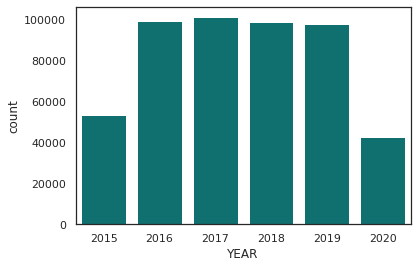

In [109]:
# Year Trends
sns.countplot(x='YEAR', data=crimedata, color='teal')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


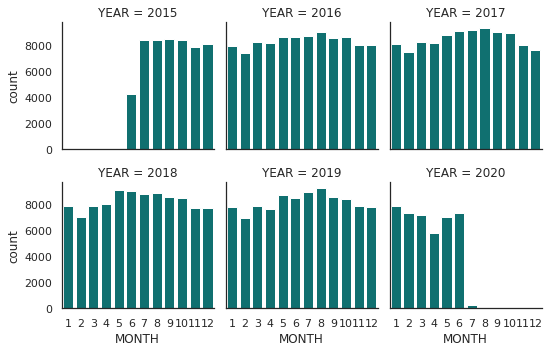

In [110]:
# Month Trends
g =sns.factorplot(x='MONTH', col='YEAR', kind='count', data=crimedata,
                  col_wrap=3, size=2.5, color='teal')

plt.show()

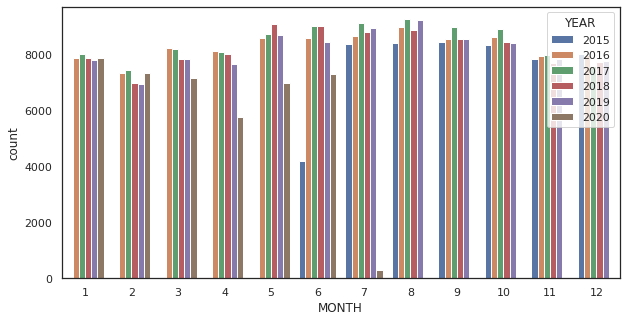

In [111]:
# Year/Month Trends
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

sns.countplot(x="MONTH", hue='YEAR', data=crimedata)
plt.show()

**Observation** Crime incidents have been slightly trenidng down since year 2017. Summer months May through August tend to observe a larger number of crimes, while winter months November through February tend to see a relatively smaller number of crimes.

In [112]:
# offense description groupby
offense_desc_groupby=crimedata.groupby("OFFENSE_DESCRIPTION").size().reset_index()
# offense description groupby
offense_group_groupby=crimedata.groupby("OFFENSE_CODE_GROUP").size().reset_index()

In [113]:
offense_desc_groupby.columns=['OFFENSE_DESCRIPTION', "COUNT"]
offense_group_groupby.columns=['OFFENSE_CODE_GROUP', "COUNT"]

**Most Common Crime in Boston**

In [114]:
# Show top 10 offense types
offense_desc_groupby.sort_values("COUNT",ascending=False).head(10)

,OFFENSE_DESCRIPTION,COUNT
135,INVESTIGATE PERSON,30280
249,SICK/INJURED/MEDICAL - PERSON,28616
173,M/V - LEAVING SCENE - PROPERTY DAMAGE,24772
266,VERBAL DISPUTE,24053
265,VANDALISM,22385
21,ASSAULT SIMPLE - BATTERY,19888
136,INVESTIGATE PROPERTY,17791
256,TOWED MOTOR VEHICLE,16811
255,THREATS TO DO BODILY HARM,13978
163,LARCENY THEFT FROM BUILDING,13562


_Top 10 Offense Crime Incidents_

Text(0.5, 1.0, 'Top 10 Offense Descriptions')

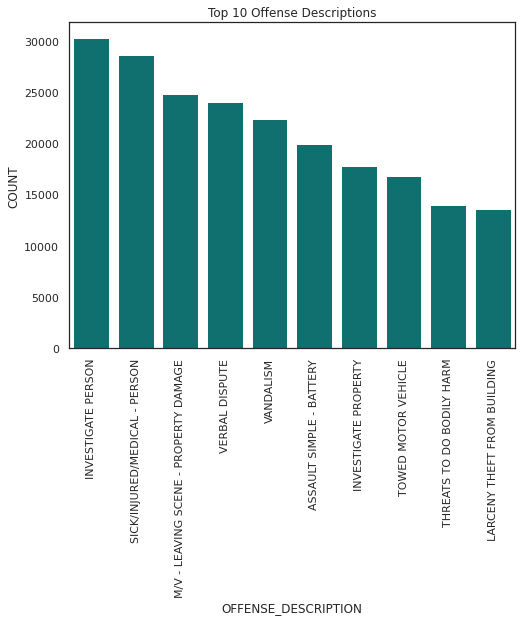

In [115]:
plt.figure(figsize=(8, 6))
chart=sns.barplot(x="OFFENSE_DESCRIPTION",y="COUNT",data=offense_desc_groupby.sort_values("COUNT",ascending=False).head(10),color = 'teal')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_title('Top 10 Offense Descriptions')

**Most Common Crime Group in Boston**

In [116]:
# Show top 5 offense group types
offense_group_groupby.sort_values("COUNT",ascending=False).head()

,OFFENSE_CODE_GROUP,COUNT
43,Motor Vehicle Accident Response,49603
34,Larceny,34750
40,Medical Assistance,32741
31,Investigate Person,24754
46,Other,24050


_Top 10 Crime Group Incidents_

Text(0.5, 1.0, 'Top 10 Crime Groups')

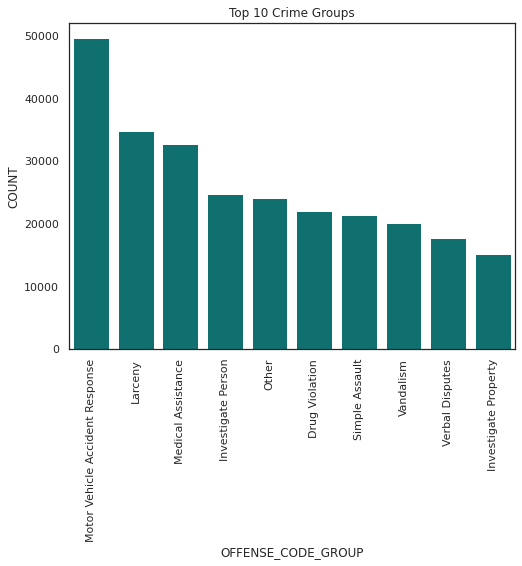

In [117]:
plt.figure(figsize=(8, 6))
chart=sns.barplot(x="OFFENSE_CODE_GROUP",y="COUNT",data=offense_group_groupby.sort_values("COUNT",ascending=False).head(10),color = 'teal')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_title('Top 10 Crime Groups')

**District Distribution of Crime Incidents**

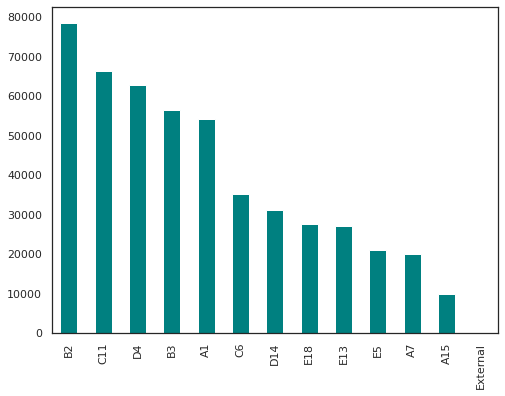

In [118]:
import seaborn as sns; sns.set(style='white')
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

crimedata['DISTRICT'].value_counts().plot(kind="bar",color="teal")

plt.show()



---



---


**The descriptive analysis shows the high crime incidents districts, trend over the years, and the most common crime and crime categories in Boston. Next, we would want to undersatnd the number of crimes that take place within a neighborhood.**

*Note: All the crimes that did not have latitude and longitude will be dropped, which may skew the data to certain extent.* 

### __Boston Neighborhoods__

#### __Load, Prepare, and Explore Data__

**Download, Import and Explore Boston Neighborhoods Geo Data**

The dataset exists for free on the Boston Opendata website. Link to the dataset is attached: [Boston GeoData](http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.geojson?outSR={%22latestWkid%22:2249,%22wkid%22:102686)

In [119]:
!wget -q -O 'boston_data.json' http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.geojson?outSR={%22latestWkid%22:2249,%22wkid%22:102686
print('Data downloaded!')

Data downloaded!


Load and explore the data

In [120]:
#import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json

with open('boston_data.json','r') as json_data:
    boston_geojson = json.load(json_data)

In [121]:
boston_geojson

{'crs': {'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'},
  'type': 'name'},
 'features': [{'geometry': {'coordinates': [[[[-71.12592717485386,
        42.272013107957406],
       [-71.12610933458738, 42.2716219294518],
       [-71.12603188298199, 42.27158985153841],
       [-71.12571713956957, 42.27152070474045],
       [-71.12559042372907, 42.27146017841939],
       [-71.12523676125656, 42.271387313901805],
       [-71.12522437821433, 42.271425073651166],
       [-71.12489533053173, 42.27134458090032],
       [-71.12482468090687, 42.271318140479686],
       [-71.12485155056099, 42.27124753819149],
       [-71.12476329046935, 42.270292339717635],
       [-71.12470249712558, 42.270295367758344],
       [-71.12259088359436, 42.2700534081311],
       [-71.1223931813923, 42.27003085475475],
       [-71.12252039300371, 42.269427196690025],
       [-71.12214745279846, 42.26937277217365],
       [-71.12192848881409, 42.27038614438027],
       [-71.1221406576364, 42.27041692631439],
 

Define a new variable that includes the relevant data, which is in the *features* key, a list of the neighborhoods.

In [122]:
features = boston_geojson['features']

In [123]:
neighborhood_list = []
for feature in features:
  neighborhood_list.append(feature['properties']['Name'])
print(neighborhood_list)

['Roslindale', 'Jamaica Plain', 'Mission Hill', 'Longwood', 'Bay Village', 'Leather District', 'Chinatown', 'North End', 'Roxbury', 'South End', 'Back Bay', 'East Boston', 'Charlestown', 'West End', 'Beacon Hill', 'Downtown', 'Fenway', 'Brighton', 'West Roxbury', 'Hyde Park', 'Mattapan', 'Dorchester', 'South Boston Waterfront', 'South Boston', 'Allston', 'Harbor Islands']


In [124]:
# define the dataframe columns
column_names = ['Neighborhood', 'SqMiles', 'Latitude', 'Longitude'] 
# instantiate the dataframe
boston_neighborhoods = pd.DataFrame(columns=column_names)

In [125]:
boston_neighborhoods

,Neighborhood,SqMiles,Latitude,Longitude


Loop through the data and fill the dataframe. Note that the the coordinates are multipolygon type. A centroid method was used to extract a single set of geocodes to represent each Neighborhood.

In [126]:
from shapely.geometry import Point, shape, Polygon

In [127]:
for feature in features:
    neighborhood_name = feature['properties']['Name']
    area = feature['properties']['SqMiles']
    polygon = shape(feature['geometry'])
    boston_neighborhoods = boston_neighborhoods.append({'Neighborhood': neighborhood_name,
                                          'SqMiles': area,
                                          'Latitude': polygon.centroid.y,
                                          'Longitude': polygon.centroid.x}, ignore_index=True)

In [128]:
boston_neighborhoods.head()

,Neighborhood,SqMiles,Latitude,Longitude
0,Roslindale,2.51,42.282524,-71.126663
1,Jamaica Plain,3.94,42.307770,-71.115097
2,Mission Hill,0.55,42.331741,-71.102607
3,Longwood,0.29,42.338609,-71.105103
4,Bay Village,0.04,42.349103,-71.069032


In [129]:
print('The dataframe has {} neighborhoods in Boston.'.format(
        boston_neighborhoods.shape[0])        
    )

The dataframe has 26 neighborhoods in Boston.


#### __Map of Boston City__

_With Neighborhoods superimposed on Map of Boston City_

In [130]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston City are 42.3602534, -71.0582912.


In [131]:
map_boston = folium.Map(location=[latitude, longitude], 
                        #tiles='Stamen Toner', 
                        zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(boston_neighborhoods['Latitude'], boston_neighborhoods['Longitude'], boston_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='teal',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8,
        parse_html=False).add_to(map_boston)  
    
map_boston

### __Merge and Clean__

Add Neighborhood field to the crime incident dataframe. 

In [140]:
resp=requests.get('http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.geojson?outSR={%22latestWkid%22:2249,%22wkid%22:102686}').json()

In [141]:
def point_to_neighborhood (lat, long, geojson):
    point = Point(long, lat)
    features = resp['features']
    for feature in features:
        polygon = shape(feature['geometry'])
        neighborhood = feature['properties']['Name']
        if polygon.contains(point):
            if neighborhood == 'Chinatown' or neighborhood == 'Leather District':
                return 'Downtown'
            elif neighborhood == 'Bay Village':
                return 'South End'
            else:
                return neighborhood
    print(f'Point ({long},{lat}) is not in Boston.')
    return None

In [142]:
crimedata_nona = crimedata.dropna(subset = ['Lat','Long'])
crimedata_nona.shape

(465499, 16)

In [143]:
for index, row in crimedata_nona.iterrows():
    lat = crimedata_nona.at[index, 'Lat']
    long = crimedata_nona.at[index, 'Long']
    #print(index)
    #print(lat)
    #print(long)
    neighborhood = point_to_neighborhood(lat, long, resp)
    #print(neighborhood)
    crimedata_nona.at[index, 'Neighborhood'] = neighborhood

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.03973966,42.28458088) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.10696156,42.34821076) is not in Boston.
Point (-71.07040347,42.39049131) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.03973966,42.28458088) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Poin

In [137]:
crimedata_nona.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long
1,S47513131,2647,NaN,THREATS TO DO BODILY HARM,E18,530,0,2020-06-24 10:15:00,2020,6,Wednesday,10,NaN,READVILLE ST,42.239491,-71.135954
2,I92102201,3301,NaN,VERBAL DISPUTE,E13,583,0,2019-12-20 03:08:00,2019,12,Friday,3,NaN,DAY ST,42.325122,-71.107779
3,I92097173,3115,NaN,INVESTIGATE PERSON,C11,355,0,2019-10-23 00:00:00,2019,10,Wednesday,0,NaN,GIBSON ST,42.297555,-71.059709
4,I92094519,3126,NaN,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,D14,765,0,2019-11-22 07:50:00,2019,11,Friday,7,NaN,BROOKS ST,42.355120,-71.162678
5,I92089785,3005,NaN,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,NaN,WASHINGTON ST,42.309718,-71.104294


*Merge  Boston Neighborhoods dataframe and Crime dataframe, and count number of crimes by Neighborhoods.*

In [144]:
crime_neighborhood = crimedata_nona.groupby('Neighborhood').size().reset_index(name = 'count').set_index('Neighborhood')

In [145]:
merge=pd.merge(crime_neighborhood,boston_neighborhoods,on='Neighborhood',sort=True)
merge

,Neighborhood,count,SqMiles,Latitude,Longitude
0,Allston,12644,1.56,42.358405,-71.128563
1,Back Bay,18015,0.62,42.349861,-71.080535
2,Beacon Hill,4013,0.31,42.357050,-71.068262
3,Brighton,17243,2.88,42.348357,-71.154935
4,Charlestown,9112,1.36,42.379310,-71.063767
5,Dorchester,116106,7.29,42.298462,-71.063457
6,Downtown,35820,0.62,42.355593,-71.057651
7,East Boston,19702,4.71,42.372679,-71.015695
8,Fenway,12597,0.88,42.344767,-71.096115
9,Harbor Islands,6,1.29,42.327941,-70.968775


In [ ]:
map_boston = folium.Map(location=[latitude, longitude], 
                                  #tiles='Stamen Toner', 
                                  zoom_start=12)

incidents = folium.map.FeatureGroup()

# loop through each crime and add dach to the incidents feature group
for lat, lng in zip(crimedata_nona.Lat, crimedata_nona.Long):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
map_boston.add_child(incidents)

In [ ]:
# display map
# as this is huge map data , we will save it to a file
map_boston.save('boston_crime.html')

### __Venue Data from Foursquare__

*Explore if there exists any association between number of Police Station and crime incidence rates.*

#### __Request, Load, Prepare Data__

In [ ]:
#@title
# Foursquare Credentials and Version.
CLIENT_ID = 'WFPGX20PHLXCGUGMROEBZZPVS0XBJQR0N5WS54WKLFRTEE3B' # your Foursquare ID
CLIENT_SECRET = 'P414KZXRB5A2AG0H5RXBXCPG0XVCLPUCLHJAA2COXRFLA44Y' # your Foursquare Secret
VERSION = '20190425' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

This function will extract the Police Station venues (parameter *categoryId* inserted in the request URL) within a radius of 5000 meters of each neighborhood's centroid.

In [149]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId=4bf58dd8d48988d12e941735&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each neighborhood and create a new dataframe

In [150]:
boston_venues = getNearbyVenues(names=merge['Neighborhood'],
                                latitudes=merge['Latitude'],
                                longitudes=merge['Longitude']
                                )

Allston
Back Bay
Beacon Hill
Brighton
Charlestown
Dorchester
Downtown
East Boston
Fenway
Harbor Islands
Hyde Park
Jamaica Plain
Longwood
Mattapan
Mission Hill
North End
Roslindale
Roxbury
South Boston
South Boston Waterfront
South End
West End
West Roxbury


In [151]:
print(boston_venues.shape)
boston_venues

(467, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allston,42.358405,-71.128563,Boston University Police Station,42.352361,-71.118470,Police Station
1,Allston,42.358405,-71.128563,Mass State Police H5 Brighton,42.362389,-71.143929,Police Station
2,Allston,42.358405,-71.128563,Harvard University Police Department,42.369880,-71.112101,Police Station
3,Allston,42.358405,-71.128563,MIT Police (Building W89),42.355546,-71.104676,Police Station
4,Allston,42.358405,-71.128563,Boston Police D-14,42.349644,-71.150468,Police Station
...,...,...,...,...,...,...,...
462,West Roxbury,42.280642,-71.160027,Boston Police E-5,42.287091,-71.148411,Police Station
463,West Roxbury,42.280642,-71.160027,Dedham Police Headquarters,42.248231,-71.173848,Police Station
464,West Roxbury,42.280642,-71.160027,Dedham Police Central Dispatch,42.248048,-71.174021,Police Station
465,West Roxbury,42.280642,-71.160027,Boston Police E-18,42.256470,-71.124222,Police Station


#### __Map of Police Stations__
Map of Boston Police Stations by Neighborhood

In [152]:
map2_boston = folium.Map(location=[latitude, longitude], 
                        #tiles='Stamen Toner', 
                        zoom_start=11)

# add markers to map
for lat, lng, bpd in zip(boston_venues['Venue Latitude'], boston_venues['Venue Longitude'], boston_venues['Venue']):
    label = '{}'.format(bpd)
    label = folium.Popup(label, parse_html=False, max_width='100%', show=False,sticky=False)
    folium.Marker(
        [lat, lng],
        popup=label,
        #color='teal',
        #fill=True,
        #fill_opacity=0.8,
        #parse_html=False
        ).add_to(map2_boston) 
    
map2_boston


How many Police Stations are there in each neighborhood?

In [153]:
boston_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allston,18,18,18,18,18,18
Back Bay,30,30,30,30,30,30
Beacon Hill,29,29,29,29,29,29
Brighton,13,13,13,13,13,13
Charlestown,22,22,22,22,22,22
Dorchester,19,19,19,19,19,19
Downtown,28,28,28,28,28,28
East Boston,15,15,15,15,15,15
Fenway,30,30,30,30,30,30


In [154]:
# Count Police Station by Neighborhood
bpd=boston_venues.groupby("Neighborhood").size().reset_index()
bpd.columns=['Neighborhood', "BPDNumber"]
bpd

,Neighborhood,BPDNumber
0,Allston,18
1,Back Bay,30
2,Beacon Hill,29
3,Brighton,13
4,Charlestown,22
5,Dorchester,19
6,Downtown,28
7,East Boston,15
8,Fenway,30
9,Harbor Islands,1


### __Merge and Clean 2__

In [155]:
crime_bpd=pd.merge(merge, bpd,on='Neighborhood',sort=True)
crime_bpd

,Neighborhood,count,SqMiles,Latitude,Longitude,BPDNumber
0,Allston,12644,1.56,42.358405,-71.128563,18
1,Back Bay,18015,0.62,42.349861,-71.080535,30
2,Beacon Hill,4013,0.31,42.357050,-71.068262,29
3,Brighton,17243,2.88,42.348357,-71.154935,13
4,Charlestown,9112,1.36,42.379310,-71.063767,22
5,Dorchester,116106,7.29,42.298462,-71.063457,19
6,Downtown,35820,0.62,42.355593,-71.057651,28
7,East Boston,19702,4.71,42.372679,-71.015695,15
8,Fenway,12597,0.88,42.344767,-71.096115,30
9,Harbor Islands,6,1.29,42.327941,-70.968775,1


In [232]:
import pandas as pd
crime_cluster=crime_bpd
crime_cluster['crimedensity'] = crime_bpd['count'] / crime_bpd['SqMiles']
crime_cluster['bpddensity'] = crime_bpd['BPDNumber'] / crime_bpd['SqMiles']
crime_cluster.sort_values("count",ascending=False)

,Neighborhood,count,SqMiles,Latitude,Longitude,BPDNumber,crimedensity,bpddensity
17,Roxbury,61607,3.29,42.318519,-71.086643,25,18725.531915,7.598784
6,Downtown,35820,0.62,42.355593,-71.057651,28,57774.193548,45.161290
11,Jamaica Plain,23421,3.94,42.307770,-71.115097,17,5944.416244,4.314721
18,South Boston,22968,2.25,42.334909,-71.044644,27,10208.000000,12.000000
20,South End,22230,0.74,42.341350,-71.071369,30,30040.540541,40.540541
13,Mattapan,21000,2.11,42.277005,-71.091446,8,9952.606635,3.791469
10,Hyde Park,20582,4.57,42.255035,-71.126299,6,4503.719912,1.312910
7,East Boston,19702,4.71,42.372679,-71.015695,15,4183.014862,3.184713
1,Back Bay,18015,0.62,42.349861,-71.080535,30,29056.451613,48.387097
3,Brighton,17243,2.88,42.348357,-71.154935,13,5987.152778,4.513889


### __Correlation__

Examine if there is association between 1) number of Police Station and number of crimes across all Neighborhoods, 2) Police Station density and crime incidents density (per square mile).

#### __1) Association between the number of Police Station and number of crimes__

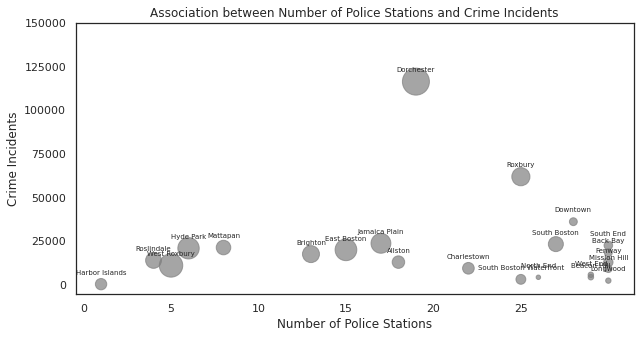

In [157]:
# 1) number of Police Station and number of crimes
sns.set(style="white")

xs=crime_cluster['BPDNumber']
ys=crime_cluster['count']
neighborhoods=crime_cluster['Neighborhood']
area = crime_cluster['SqMiles'] * 100

plt.scatter(xs, ys, c='#7f7f7f', s=area, alpha=0.7)

# zip joins x and y coordinates in pairs
for x,y,neighborhood in zip(xs,ys,neighborhoods):

    label = "{}".format(neighborhood) 
            #& "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 size=7)

plt.xticks(np.arange(0,30,5))
plt.yticks(np.arange(0,175000,25000))
plt.xlabel("Number of Police Stations")
plt.ylabel("Crime Incidents")
plt.title("Association between Number of Police Stations and Crime Incidents")
plt.show()

If excluding Dorchester, a seemingly outlier, will it show a different picture? 

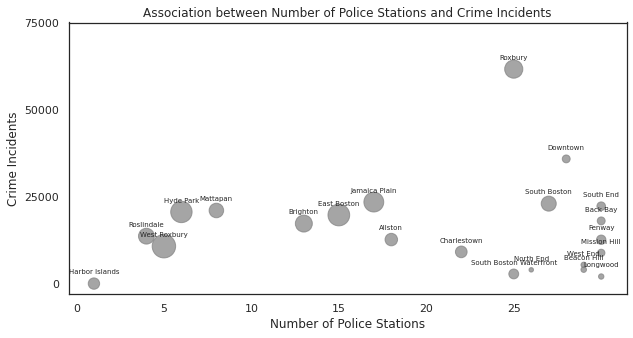

In [166]:
sns.set(style="white")

xs=crime_cluster['BPDNumber']
ys=crime_cluster['count']
neighborhoods=crime_cluster['Neighborhood']
area = crime_cluster['SqMiles'] * 100

plt.scatter(xs, ys, c='#7f7f7f', s=area, alpha=0.7)

# zip joins x and y coordinates in pairs
for x,y,neighborhood in zip(xs,ys,neighborhoods):

    label = "{}".format(neighborhood) 
            #& "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 size=7)

plt.xticks(np.arange(0,30,5))
plt.yticks(np.arange(0,100000,25000))
plt.xlabel("Number of Police Stations")
plt.ylabel("Crime Incidents")
plt.title("Association between Number of Police Stations and Crime Incidents")
plt.show()

**Observation** 

The scatter chart illustrates the relationship between number of police stations and crime incidents by neighborhood. Specifically, the horizontal axis represents the number of police station, vertical axis represents crime incidents, and the size of the circle marker represents square miles of a neighborhood.  


*   As the chart shows, Dorchester neighborhood has the largest number of crime incidents, followed by Roxbury, and then Downtown. These three neighborhoods have 19, 25, and 28 Police Stations within the boundary of the neighborhoods, respectively.
*   There is no apparent pattern between the number of police stations and crime incidents. 




#### __2) Association between Police Station Density and Crime Incident Density__

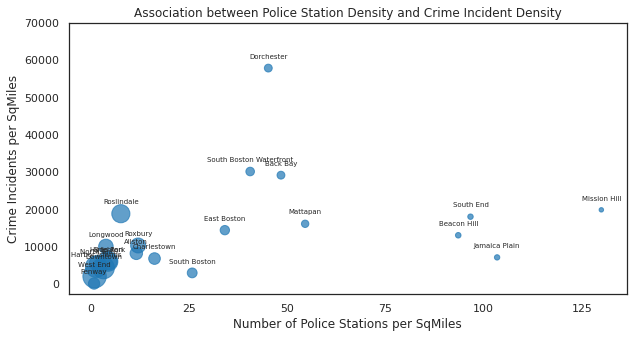

In [165]:
# 2) Police Station density and crime incidents density
sns.set(style="white")

xxs=crime_cluster['bpddensity']
yys=crime_cluster['crimedensity']
area = crime_cluster['SqMiles'] * 100

plt.scatter(xxs, yys, c='#1f77b4', s=area, alpha=0.7)

# zip joins x and y coordinates in pairs
for x,y,neighborhood in zip(xxs,yys,neighborhoods):

    label = "{}".format(neighborhood) 
            #& "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 size=7)

plt.xticks(np.arange(0,150,25))
plt.yticks(np.arange(0,80000,10000))
plt.xlabel("Number of Police Stations per SqMiles")
plt.ylabel("Crime Incidents per SqMiles")
plt.title("Association between Police Station Density and Crime Incident Density")
plt.show()

#### __3) K Nearest Neighbor Clustering__

In [170]:
import itertools
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier

In [194]:
X = crime_cluster[['BPDNumber', 'bpddensity','SqMiles']].values  #.astype(float)
X[0:5]

array([[18.        , 11.53846154,  1.56      ],
       [30.        , 48.38709677,  0.62      ],
       [29.        , 93.5483871 ,  0.31      ],
       [13.        ,  4.51388889,  2.88      ],
       [22.        , 16.17647059,  1.36      ]])

In [199]:
y = crime_cluster[['count']].values
y[0:5]

array([[12644],
       [18015],
       [ 4013],
       [17243],
       [ 9112]])

In [196]:
# normalize data
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.24015466, -0.57650379, -0.204315  ],
       [ 0.97909207,  0.38507788, -0.79774678],
       [ 0.87748817,  1.56358202, -0.99345301],
       [-0.74817413, -0.75981317,  0.62901473],
       [ 0.16626092, -0.45547287, -0.33057708]])

Train and test split

In [197]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (17, 3) (17, 1)
Test set: (5, 3) (5, 1)


Classification

In [178]:
from sklearn.neighbors import KNeighborsClassifier

Training

In [225]:
k = 10
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

Predicting

In [226]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([2034, 2034, 2771,    6,    6])

Accuaracy evaluating

In [227]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.17647058823529413
Test set Accuracy:  0.0
